<a href="https://colab.research.google.com/github/rasulamirov/Data-Importation-Curve_Fitting_of_Fluorescence_Spectroscopy_Measurements/blob/main/curve_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy as sp
import struct
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#### Data preparation
Need to import the text and the binary files for future use

In [ ]:
def conv(b):
    return b/65535.0*10.0

In [ ]:
t = np.arange(0,1000,0.2)

## TXTXTTXTTXTXTXTXTTX
FID1 = open(r"Data1.txt", 'tr')
FID2 = open(r"Data2.txt", 'tr')
FID3 = open(r"Data3.txt", 'tr')
FID5 = open(r"Data5.txt", 'tr')
FID6 = open(r"Data6.txt", 'tr')


FID = [FID1,FID2,FID3,FID5,FID6]




Y = []
for i in range(len(FID)):
    Y.append(FID[i].read().split('\n'))
    Y[i] = [float(i) for i in Y[i]]
    Y[i] = np.array(Y[i])
    FID[i].close()


############ BINARIARY
FID4 = open(r"Data4.dat", 'rb')
buf = FID4.read()
lst = []
binList = struct.iter_unpack('H', buf)
lst = [i[0] for i in binList]
arr = np.array(lst)
FID4.close()
Y4 = conv(arr)
Y.insert(3, Y4)


t = np.arange(0,1000.05, 0.05)
tao = np.array([200.9,5.8,38.6,516.2,57.8,8.9])

#### Fitting with cost function
I defined a cost funciton, it gives almost perfect results, but takes about 2 minutes to execute
** update - I vectorized this stuff, to run the whole 6 solution check in 10 sec

In [ ]:
def totalFluorescence(A,t):#works 
    tao = np.array([200.9,5.8,38.6,516.2,57.8,8.9])

    return A[0]*np.exp(-t/tao[0])+A[1]*np.exp(-t/tao[1])+A[2]*np.exp(-t/tao[2])+A[3]*np.exp(-t/tao[3])+A[4]*np.exp(-t/tao[4])+A[5]*np.exp(-t/tao[5])

In [ ]:
def costFunction(A, data):
    model = totalFluorescence(A, t)
    errorVect = abs(data-model)
    return np.mean(errorVect)

In [ ]:
def findCoefficients(t,Y):# data for several solutions
    dd = pd.DataFrame(columns=['Naphtalene','Anthracene','Benzopyrene','Pyrene','Chrysene','Benzofluoranthene'])
    n_compounds = dd.shape[1]
    for i in range(len(Y)):
        fG = [np.random.uniform(0,15) for i in range(n_compounds)]
        res = sp.optimize.minimize(costFunction,fG, args=(Y[i]))
        s = pd.DataFrame([res.x], columns=['Naphtalene','Anthracene','Benzopyrene','Pyrene','Chrysene','Benzofluoranthene'])
        dd = pd.concat([dd,s], axis=0, ignore_index=True)
    return dd

In [ ]:
df = findCoefficients(t, Y)

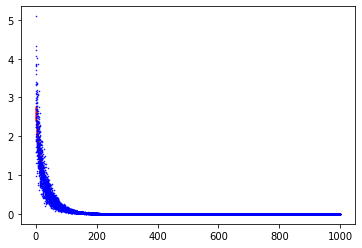

In [ ]:
sol_n_minimized = 5

plt.scatter(t,totalFluorescence(df.iloc[sol_n_minimized], t),c='r', label='model', s=0.3)
plt.scatter(t,Y[sol_n_minimized],c='b', label='data', s=0.3)
plt.show()

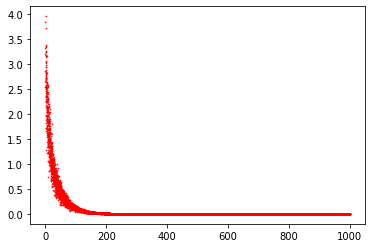

In [ ]:
plt.scatter(t,Y[4],c='r', label='data',s=0.4)


#### Testing some other total fluorescence function

In [ ]:
def totalFluorescenceGeneral(A,t):#works 
    tao = np.array([200.9,5.8,38.6,516.2,57.8,8.9])
    return np.divide(np.broadcast_to(t,shape=(6,20001)).T,tao).sum(axis=0)

In [ ]:
np.divide(np.broadcast_to(t,shape=(6,20001)).T,tao).sum(axis=0)

array([  49778.49676456, 1724224.13793103,  259080.31088083,
         19373.30492057,  173019.03114187, 1123651.68539326])

In [ ]:
import time
tot = []
for j in range(500,600):
    tt = tt1 =0
    for i in range(j):
        tic = time.perf_counter()
        np.outer(t.reshape(t.shape[0],-1),1/tao).sum(axis=0)
        toc = time.perf_counter()
        tt+=toc-tic
        tic = time.perf_counter()
        np.divide(np.broadcast_to(t,shape=(6,20001)).T,tao).sum(axis=0)
        toc = time.perf_counter()
        tt1+=toc-tic
    tot.append([tt,tt1])

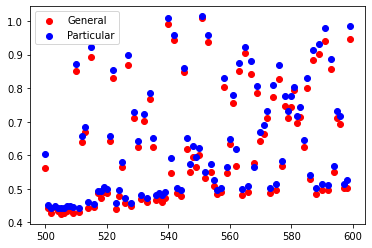

In [ ]:
plt.scatter(np.arange(500,600),np.array(tot)[:,0],c='r',label='General')
plt.scatter(np.arange(500,600),np.array(tot)[:,1],c='b',label='Particular')
plt.legend()
plt.show()

#### Optimization with curve_fitting and comparison with minimization

In [ ]:
def totalFluorescenceDifferent(t,A1,A2,A3,A4,A5,A6):#works 
    tao = np.array([200.9,5.8,38.6,516.2,57.8,8.9])

    return A1*np.exp(-t/tao[0])+A2*np.exp(-t/tao[1])+A3*np.exp(-t/tao[2])+A4*np.exp(-t/tao[3])+A5*np.exp(-t/tao[4])+A6*np.exp(-t/tao[5])

In [ ]:
def findCoefficientsOptimization(t,Y):# data for several solutions
    dd = pd.DataFrame(columns=['Naphtalene','Anthracene','Benzopyrene','Pyrene','Chrysene','Benzofluoranthene'])
    #n_compounds = dd.shape[1]
    for i in range(len(Y)):
        #fG = [np.random.uniform(0,15) for i in range(n_compounds)]
        #popt, pcov = sp.optimize.curve_fit(totalFluorescence,t, Y[i])
        # bounds - limits of the coefficients
        popt, pcov = sp.optimize.curve_fit(totalFluorescenceDifferent,t, Y[i], bounds=(0, [10., 10., 10., 10., 10., 10.]))
        s = pd.DataFrame([popt], columns=['Naphtalene','Anthracene','Benzopyrene','Pyrene','Chrysene','Benzofluoranthene'])
        dd = pd.concat([dd,s], axis=0, ignore_index=True)
    return dd

In [ ]:
coefficients = findCoefficientsOptimization(t,Y)
coefficients

,Naphtalene,Anthracene,Benzopyrene,Pyrene,Chrysene,Benzofluoranthene
0,9.999915e-01,1.720505e-06,3.223969e-06,3.832191e-06,3.677247e-06,1.882758e-06
1,2.905004e-06,1.999991e+00,2.181238e-06,2.999998e+00,2.135735e-06,5.003219e-08
2,9.999853e-01,1.999929e+00,2.999901e+00,4.000004e+00,8.421518e-05,9.228130e-05
3,4.999727e+00,2.185219e-08,1.986513e-09,8.666941e-12,3.000275e+00,1.431289e-08
4,2.389451e-19,2.384677e-20,1.527896e+00,4.831032e-18,2.029759e-21,1.418323e+00
5,4.002272e-16,7.263170e-20,1.550811e+00,2.186189e-15,1.020626e-18,1.383265e+00


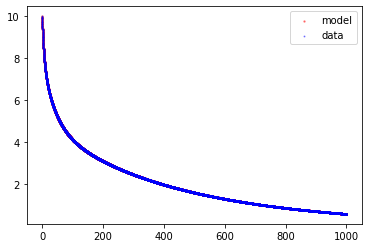

In [ ]:
# Change to see how Curve fitted model predicts for Nth sample
sol_n = 2

plt.scatter(t,totalFluorescenceDifferent(t,*coefficients.iloc[sol_n]),c='r',label='model', s=2, alpha=0.4)
plt.scatter(t,Y[sol_n],c='b',label='data', s=1,alpha=0.4)
plt.legend()
plt.show()

In [ ]:
popt, pcov = sp.optimize.curve_fit(totalFluorescenceDifferent,t, Y[3], bounds=(0, [10., 10., 10., 10., 10., 10.]))

In [ ]:
findCoefficients(t,Y)

,Naphtalene,Anthracene,Benzopyrene,Pyrene,Chrysene,Benzofluoranthene
0,1.000000e+00,-4.969085e-07,1.333670e-07,-2.187122e-08,-1.474612e-07,2.676581e-07
1,3.822812e-08,2.000000e+00,9.718994e-08,3.000000e+00,-9.881723e-08,6.807560e-08
2,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,-1.419400e-07,-3.395507e-07
3,5.000580e+00,5.069102e-04,1.188554e-03,-3.626833e-04,2.998744e+00,-7.012095e-04
4,-2.104513e-05,-3.182784e-01,1.490068e+00,2.075936e-06,5.229122e-03,1.693951e+00
5,3.023052e-05,-1.968304e-01,1.514563e+00,-2.789595e-06,-8.599343e-03,1.459918e+00


#### Just testing artificial data

In [ ]:

K = 6*np.exp(-t/200.9)+3*np.exp(-t/516.2)+8*np.exp(-t/5.8)+np.random.normal(0.5, 0.3, size=t.shape)
poptt, pcovt = sp.optimize.curve_fit(totalFluorescenceDifferent, t, K, bounds=(0,[10., 10., 10., 10., 10., 10.]))



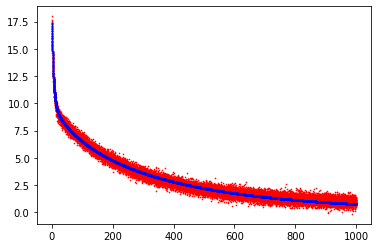

In [ ]:
plt.scatter(t, K, c='r',s=0.4)
plt.scatter(t, totalFluorescenceDifferent(t,*poptt), c='b',s=0.4)
